In [ ]:
!pip install cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import pandas as pd

# Guassian Process Regression
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should display "T4" or similar
gpu_runtime = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_runtime = torch.device("cpu")

True
Tesla T4


In [ ]:
# loading CSV data
data = pd.read_csv('west_coast_aqi.csv')
data.head()
aqi_real_unnorm = data['aqi'].copy()

0       34
1       26
2        7
3       21
4       20
        ..
4024    38
4025    39
4026    24
4027    17
4028    10
Name: aqi, Length: 4029, dtype: int64


In [ ]:
# nomralize data
scaler = MinMaxScaler()
data[['lat', 'long']] = scaler.fit_transform(data[['lat', 'long']])
data['aqi'] = scaler.fit_transform(data[['aqi']])

lats = torch.tensor(data['lat'].values, dtype=torch.float32).unsqueeze(1)
lons = torch.tensor(data['long'].values, dtype=torch.float32).unsqueeze(1)
aqi = torch.tensor(data['aqi'].values, dtype=torch.float32).unsqueeze(1)

features = torch.cat([lats, lons], dim=1)

X_train, X_val, y_train, y_val = train_test_split(features, aqi, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.to(gpu_runtime)
y_train = y_train.to(gpu_runtime)
X_val = X_val.to(gpu_runtime)
y_val = y_val.to(gpu_runtime)

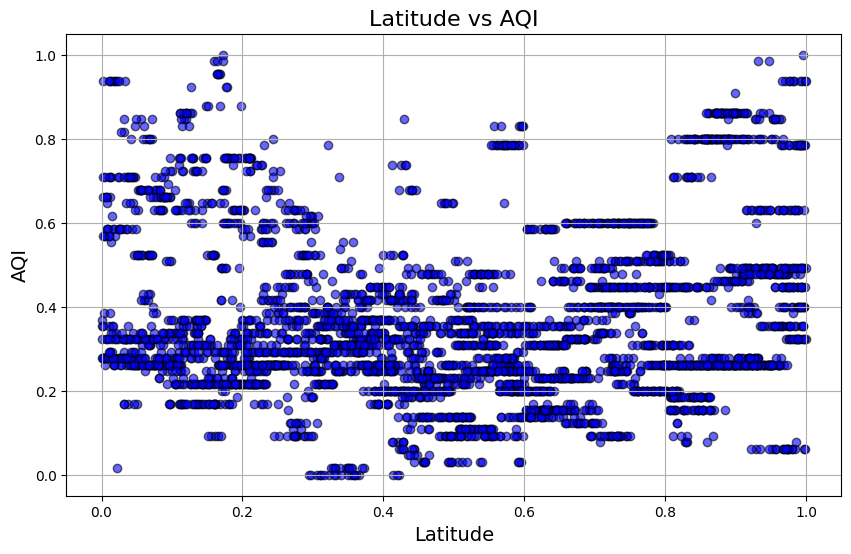

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(lats, aqi, c='blue', alpha=0.6, edgecolor='k')

plt.title('Latitude vs AQI', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('AQI', fontsize=14)
plt.grid(True)

plt.show()

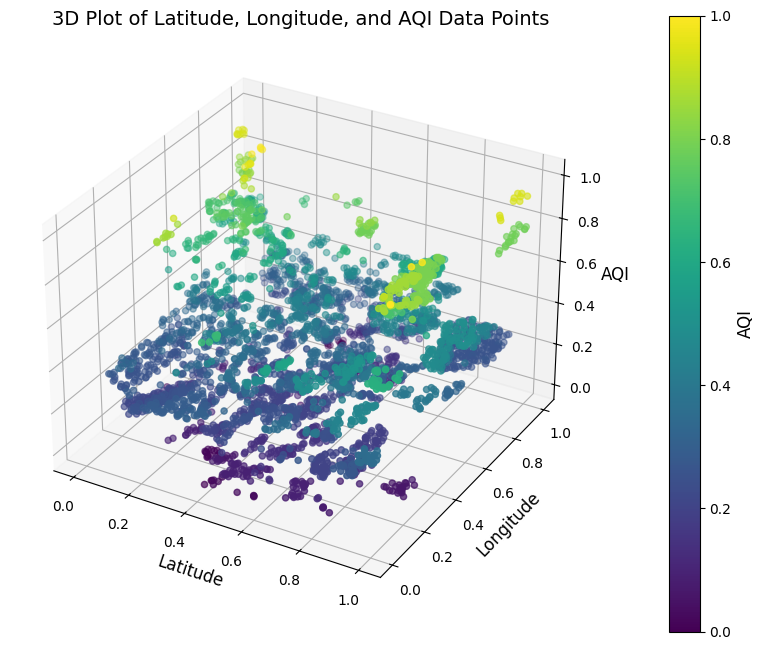

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(lats, lons, aqi, c=aqi, cmap='viridis', marker='o')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('AQI', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Latitude, Longitude, and AQI Data Points', fontsize=14)

plt.show()

In [ ]:
class LogCoshLoss(nn.Module):
    def forward(self, pred, target):
        diff = pred - target
        return torch.mean(torch.log(torch.cosh(diff + 1e-12)))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = self.linear(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out + identity if x.size() == out.size() else out

In [ ]:
class GeoSpatialNN(nn.Module):
    def __init__(self):
        super(GeoSpatialNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

model = GeoSpatialNN()

criterion = nn.HuberLoss(delta=1.0)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

model = model.to(gpu_runtime)

In [ ]:
epochs = 1000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    train_loss = criterion(predictions, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss.item():.8f}, Val Loss: {val_loss.item():.8f}")

train_losses[-1], val_losses[-1]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [100/1000] - Train Loss: 0.01657701, Val Loss: 0.01736719
Epoch [200/1000] - Train Loss: 0.01312913, Val Loss: 0.01375892
Epoch [300/1000] - Train Loss: 0.01250236, Val Loss: 0.01273530
Epoch [400/1000] - Train Loss: 0.01231511, Val Loss: 0.01237750
Epoch [500/1000] - Train Loss: 0.01216723, Val Loss: 0.01211351
Epoch [600/1000] - Train Loss: 0.01207203, Val Loss: 0.01205067
Epoch [700/1000] - Train Loss: 0.01195044, Val Loss: 0.01195741
Epoch [800/1000] - Train Loss: 0.01169757, Val Loss: 0.01186422
Epoch [900/1000] - Train Loss: 0.01158493, Val Loss: 0.01187322
Epoch [1000/1000] - Train Loss: 0.01118656, Val Loss: 0.01187236


(0.01118655875325203, 0.011872363276779652)

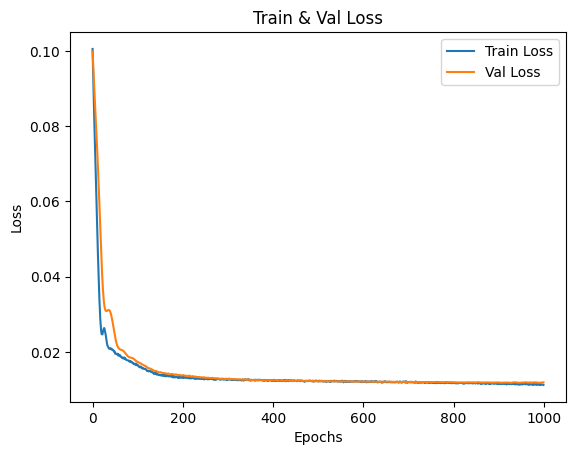

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.legend()
plt.show()

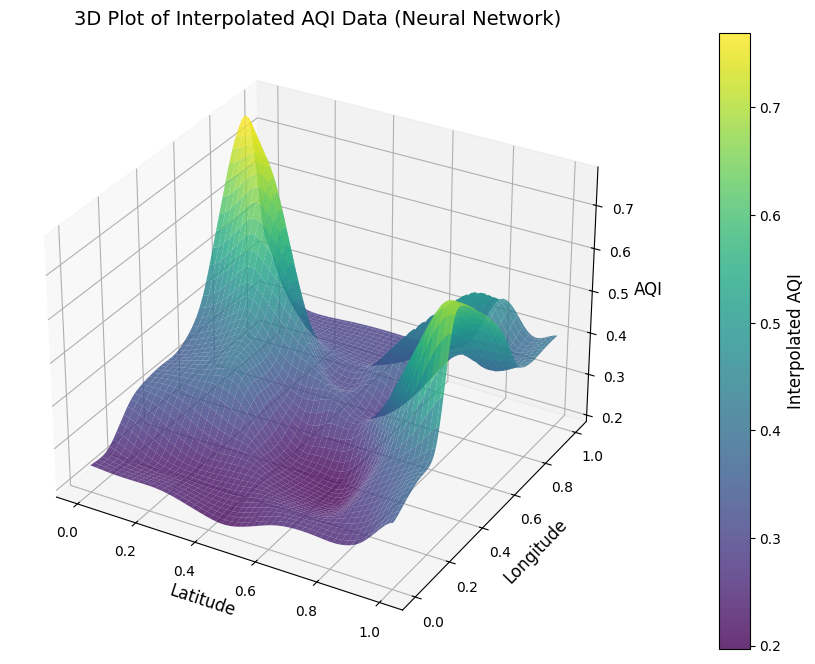

In [ ]:
grid_size = 100
lat_grid = torch.linspace(lats.min(), lats.max(), grid_size)
lon_grid = torch.linspace(lons.min(), lons.max(), grid_size)
lat_mesh, lon_mesh = torch.meshgrid(lat_grid, lon_grid, indexing='ij')
grid_features = torch.cat([lat_mesh.reshape(-1, 1), lon_mesh.reshape(-1, 1)], dim=1)

model.eval()
with torch.no_grad():
    grid_features = grid_features.to(gpu_runtime)
    aqi_pred = model(grid_features).reshape(grid_size, grid_size)

# smoothing out the outliers
aqi_pred = aqi_pred.to(cpu_runtime)
aqi_pred = gaussian_filter(aqi_pred.numpy(), sigma=2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lat_mesh.numpy(), lon_mesh.numpy(), aqi_pred,
                       cmap='viridis', edgecolor='none', alpha=0.8)

cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Interpolated AQI', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Interpolated AQI Data (Neural Network)', fontsize=14)

plt.show()

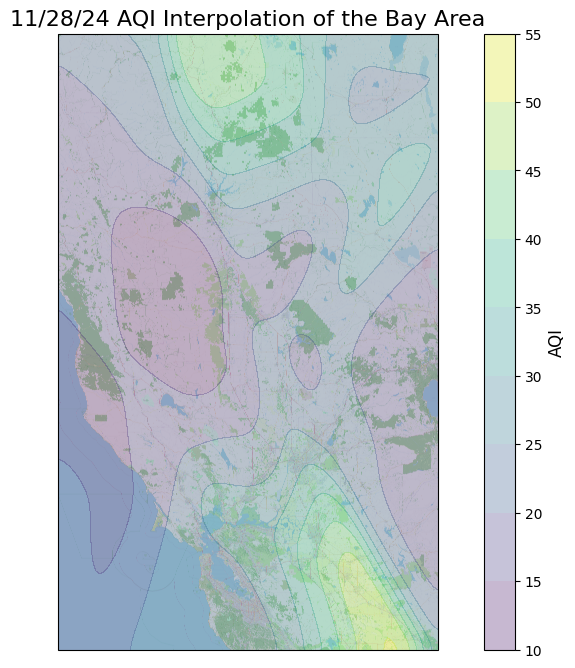

In [ ]:
lat_real = lat_mesh.numpy() * (42.0 - 37.0) + 37.0
lon_real = lon_mesh.numpy() * (-120.0 - -124.0) + -124.0

aqi_min = aqi_real_unnorm.min()
aqi_max = aqi_real_unnorm.max()

aqi_pred_unnormalized = aqi_pred * (aqi_max - aqi_min) + aqi_min

# uses Open Street Map
tiler = OSM()
mercator = tiler.crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': mercator})

lat_min, lat_max = 37.0, 42.0
lon_min, lon_max = -124.0, -120.0
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_image(tiler, 12)

# change alpha paramter for opacity (higher = more opaque)
heatmap = ax.contourf(lon_real, lat_real, aqi_pred_unnormalized.reshape(lat_real.shape),
                      transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.3)

cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('AQI', fontsize=12)

ax.set_title('11/28/24 AQI Interpolation of the Bay Area', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

# Using log-cosh loss

In [ ]:
class GeoSpatialNN(nn.Module):
    def __init__(self):
        super(GeoSpatialNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

model = GeoSpatialNN()

criterion = LogCoshLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

model = model.to(gpu_runtime)

In [ ]:
epochs = 1000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    train_loss = criterion(predictions, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss.item():.8f}, Val Loss: {val_loss.item():.8f}")

train_losses[-1], val_losses[-1]

Epoch [100/1000] - Train Loss: 0.01561283, Val Loss: 0.01630321
Epoch [200/1000] - Train Loss: 0.01282637, Val Loss: 0.01320074
Epoch [300/1000] - Train Loss: 0.01227293, Val Loss: 0.01245754
Epoch [400/1000] - Train Loss: 0.01207109, Val Loss: 0.01211670
Epoch [500/1000] - Train Loss: 0.01179672, Val Loss: 0.01189290
Epoch [600/1000] - Train Loss: 0.01173408, Val Loss: 0.01175383
Epoch [700/1000] - Train Loss: 0.01151990, Val Loss: 0.01164088
Epoch [800/1000] - Train Loss: 0.01136112, Val Loss: 0.01158086
Epoch [900/1000] - Train Loss: 0.01130414, Val Loss: 0.01155763
Epoch [1000/1000] - Train Loss: 0.01090594, Val Loss: 0.01151895


(0.010905944742262363, 0.011518949642777443)

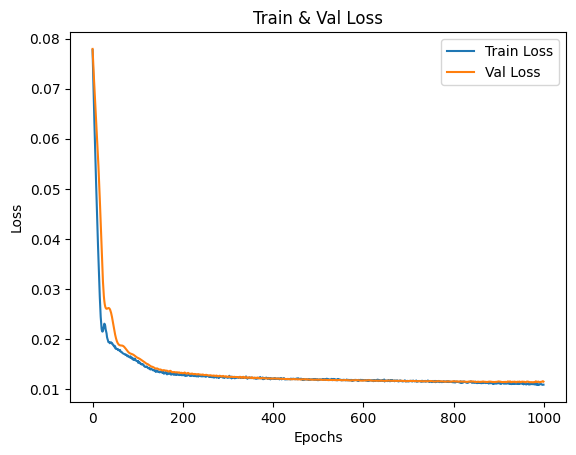

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.legend()
plt.show()

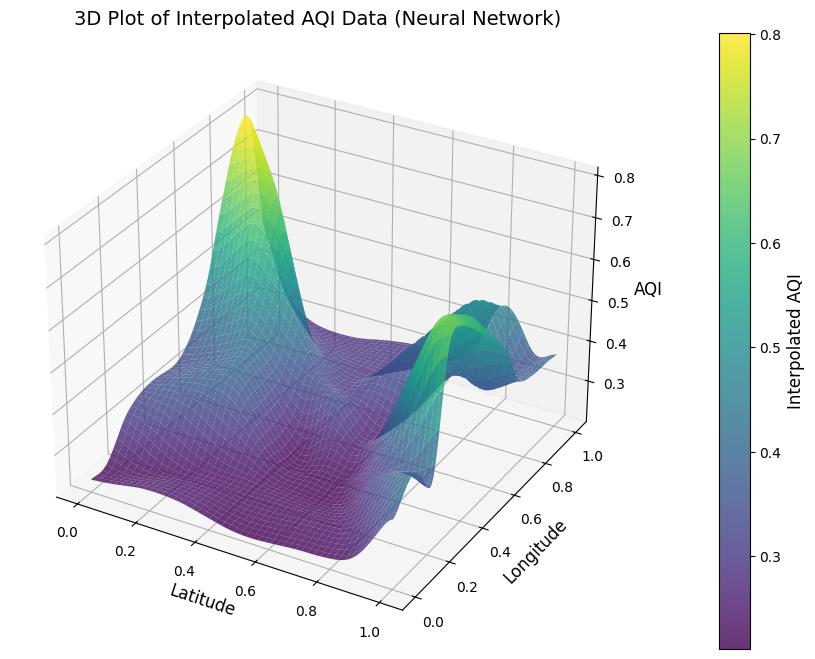

In [ ]:
grid_size = 100
lat_grid = torch.linspace(lats.min(), lats.max(), grid_size)
lon_grid = torch.linspace(lons.min(), lons.max(), grid_size)
lat_mesh, lon_mesh = torch.meshgrid(lat_grid, lon_grid, indexing='ij')
grid_features = torch.cat([lat_mesh.reshape(-1, 1), lon_mesh.reshape(-1, 1)], dim=1)

model.eval()
with torch.no_grad():
    grid_features = grid_features.to(gpu_runtime)
    aqi_pred = model(grid_features).reshape(grid_size, grid_size)

# smoothing out the outliers
aqi_pred = aqi_pred.to(cpu_runtime)
aqi_pred = gaussian_filter(aqi_pred.numpy(), sigma=2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lat_mesh.numpy(), lon_mesh.numpy(), aqi_pred,
                       cmap='viridis', edgecolor='none', alpha=0.8)

cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Interpolated AQI', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Interpolated AQI Data (Neural Network)', fontsize=14)

plt.show()

# Simpler Model (less layers)

In [ ]:
class Simpler_GeoSpatialNN(nn.Module):
    def __init__(self):
        super(Simpler_GeoSpatialNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = Simpler_GeoSpatialNN()
criterion = nn.HuberLoss(delta=1.0)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

model = model.to(gpu_runtime)

In [ ]:
epochs = 1000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    train_loss = criterion(predictions, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)


    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss.item():.8f}, Val Loss: {val_loss.item():.8f}")

train_losses[-1], val_losses[-1]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [100/1000] - Train Loss: 0.02097234, Val Loss: 0.02221430
Epoch [200/1000] - Train Loss: 0.01763970, Val Loss: 0.01869638
Epoch [300/1000] - Train Loss: 0.01482133, Val Loss: 0.01563565
Epoch [400/1000] - Train Loss: 0.01293407, Val Loss: 0.01349402
Epoch [500/1000] - Train Loss: 0.01223719, Val Loss: 0.01264543
Epoch [600/1000] - Train Loss: 0.01197887, Val Loss: 0.01232038
Epoch [700/1000] - Train Loss: 0.01180812, Val Loss: 0.01214803
Epoch [800/1000] - Train Loss: 0.01167266, Val Loss: 0.01203199
Epoch [900/1000] - Train Loss: 0.01157789, Val Loss: 0.01196244
Epoch [1000/1000] - Train Loss: 0.01149496, Val Loss: 0.01189841


(0.01149495504796505, 0.011898414231836796)

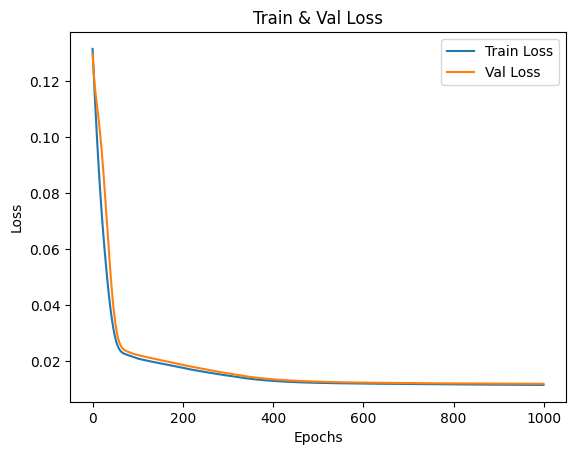

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.legend()
plt.show()

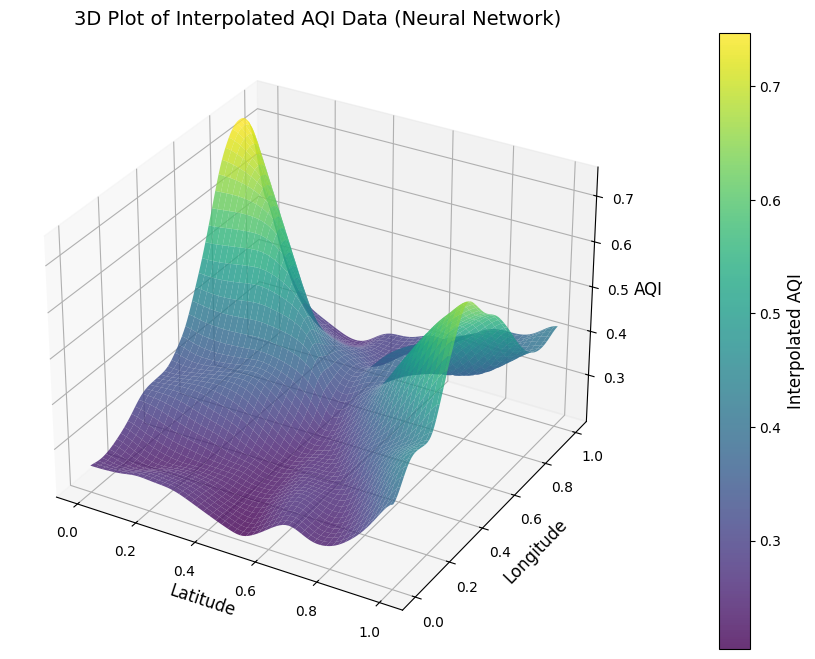

In [ ]:
grid_size = 100
lat_grid = torch.linspace(lats.min(), lats.max(), grid_size)
lon_grid = torch.linspace(lons.min(), lons.max(), grid_size)
lat_mesh, lon_mesh = torch.meshgrid(lat_grid, lon_grid, indexing='ij')
grid_features = torch.cat([lat_mesh.reshape(-1, 1), lon_mesh.reshape(-1, 1)], dim=1)

model.eval()
with torch.no_grad():
    grid_features = grid_features.to(gpu_runtime)
    aqi_pred = model(grid_features).reshape(grid_size, grid_size)

# smoothing out the outliers
aqi_pred = aqi_pred.to(cpu_runtime)
aqi_pred = gaussian_filter(aqi_pred.numpy(), sigma=2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lat_mesh.numpy(), lon_mesh.numpy(), aqi_pred,
                       cmap='viridis', edgecolor='none', alpha=0.8)

cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Interpolated AQI', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Interpolated AQI Data (Neural Network)', fontsize=14)

plt.show()

# Finite Difference Method

In [ ]:
class FiniteDifferenceInterpolation(torch.nn.Module):
    def __init__(self, grid_size):
        super(FiniteDifferenceInterpolation, self).__init__()
        self.grid_size = grid_size

    def forward(self, lats, lons, aqi):
        lat_grid = torch.linspace(lats.min(), lats.max(), self.grid_size)
        lon_grid = torch.linspace(lons.min(), lons.max(), self.grid_size)
        lat_mesh, lon_mesh = torch.meshgrid(lat_grid, lon_grid, indexing='ij')

        aqi_grid = torch.zeros_like(lat_mesh)

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                weights = 1.0 / (torch.sqrt((lats - lat_mesh[i, j])**2 + (lons - lon_mesh[i, j])**2) + 1e-5)
                aqi_grid[i, j] = torch.sum(weights * aqi) / torch.sum(weights)

        return lat_mesh, lon_mesh, aqi_grid

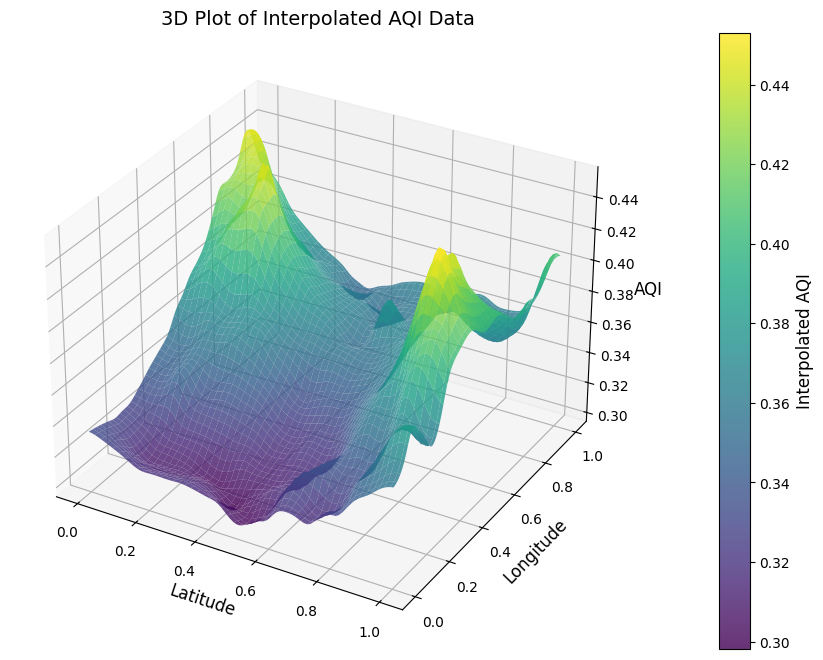

Interpolated AQI grid shape: (100, 100)
Interpolated AQI grid:
 [[0.333482   0.33334503 0.33309922 ... 0.41443834 0.41200978 0.4104969 ]
 [0.33317688 0.33303225 0.33277228 ... 0.41382897 0.4114171  0.4099329 ]
 [0.33262646 0.33246756 0.33218122 ... 0.41258413 0.41021553 0.40878633]
 ...
 [0.35744497 0.35789758 0.35879448 ... 0.4052391  0.40367275 0.40239257]
 [0.35811985 0.35856885 0.35945448 ... 0.4079658  0.40619066 0.40473887]
 [0.35846743 0.35891354 0.3597906  ... 0.40908703 0.4072214  0.40569267]]


In [ ]:
model = FiniteDifferenceInterpolation(grid_size)

lat_mesh, lon_mesh, aqi_interpolated = model(lats, lons, aqi)

# smoothing out the outliers
aqi_interpolated = gaussian_filter(aqi_interpolated.numpy(), sigma=2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lat_mesh.numpy(), lon_mesh.numpy(), aqi_interpolated,
                       cmap='viridis', edgecolor='none', alpha=0.8)

cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Interpolated AQI', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Interpolated AQI Data', fontsize=14)

plt.show()

print("Interpolated AQI grid shape:", aqi_interpolated.shape)
print("Interpolated AQI grid:\n", aqi_interpolated)

# Guassian Process Regression

In [ ]:
# NOTE: This uses northern_california_aqi.csv
# GPR is super slow with larger datasets

kernel = C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

X_train = X_train.to(cpu_runtime)
y_train = y_train.to(cpu_runtime)
X_val = X_val.to(cpu_runtime)
y_val = y_val.to(cpu_runtime)

gpr.fit(X_train, y_train)

train_predictions = gpr.predict(X_train)
val_predictions = gpr.predict(X_val)

train_loss = mean_squared_error(y_train, train_predictions)
val_loss = mean_squared_error(y_val, val_predictions)

train_loss, val_loss

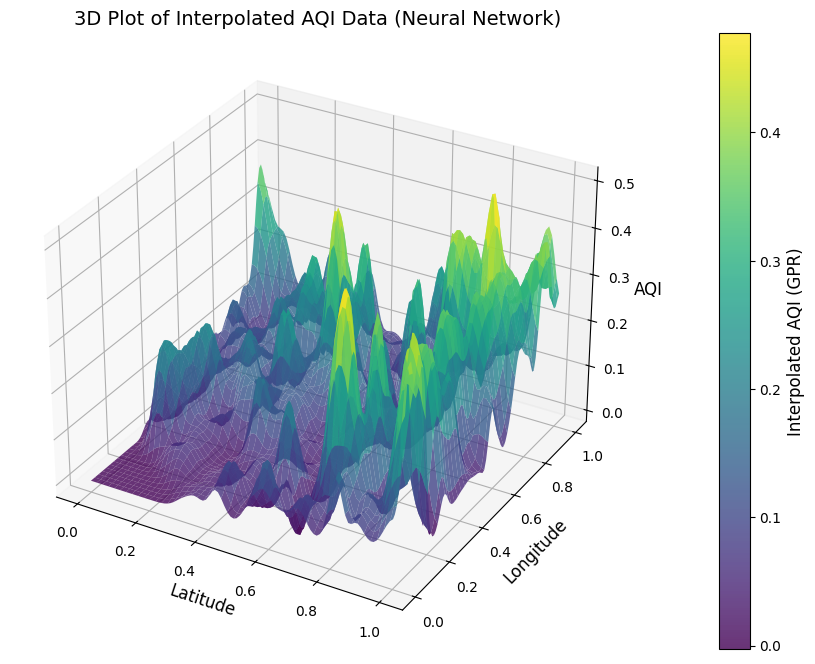

In [ ]:
grid_size = 100
lat_grid = torch.linspace(lats.min(), lats.max(), grid_size)
lon_grid = torch.linspace(lons.min(), lons.max(), grid_size)
lat_mesh, lon_mesh = torch.meshgrid(lat_grid, lon_grid, indexing='ij')
grid_features = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

gpr_mean, gpr_std = gpr.predict(grid_features, return_std=True)
gpr_mean = gpr_mean.reshape(grid_size, grid_size)
gpr_std = gpr_std.reshape(grid_size, grid_size) # uncertainty map

# smoothing out the outliers
gpr_mean = gaussian_filter(gpr_mean, sigma=2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lat_mesh, lon_mesh, gpr_mean,
                       cmap='viridis', edgecolor='none', alpha=0.8)

cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Interpolated AQI (GPR)', fontsize=12)

ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_zlabel('AQI', fontsize=12)
ax.set_title('3D Plot of Interpolated AQI Data (Neural Network)', fontsize=14)

plt.show()

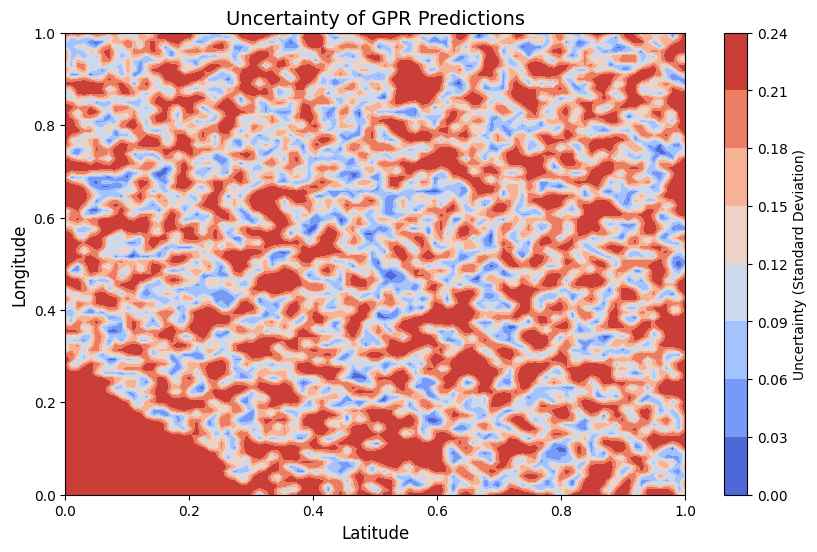

In [ ]:
lat_mesh = np.array(lat_mesh)
lon_mesh = np.array(lon_mesh)
gpr_std = np.array(gpr_std)

plt.figure(figsize=(10, 6))
plt.contourf(lat_mesh, lon_mesh, gpr_std, cmap='coolwarm')
plt.colorbar(label='Uncertainty (Standard Deviation)')
plt.title('Uncertainty of GPR Predictions', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.show()